# Проект: Приоритизация гипотез и анализ результатов A/B-теста 

**Контекст**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

**Цели проекта**

- Необходимо приоритизировать гипотезы по увеличению выручки интернет-магазина
- Запустить A/B-тест и проанализировать результаты

**План работы**

Первая часть: 
- изучение данных о гипотезах
- применение фреймворков для приоритизации гипотез 
- вывод 
Вторая часть: 
- изучение данных А/В-теста 
- предобработка данных
- построение графиков 
- рассчет статистической значимости показателей по "сырым" данным
- рассчет статистической значимости показателей по "очищенным" данным
- решение о завершении теста


**Описание данных**

Данные для первой части: 

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы 

Данные для второй части: 

В файлах /datasets/orders.csv и /datasets/visitors.csv описаны результаты проведенного A/B-теста.

Файл /datasets/orders.csv.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv. 
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Общий вывод и решение по результатам теста 

Анализ результатов A/B-теста показал, что: 

- достигнута статистическая значимость различий в среднем количестве заказов на посетителя между группами как по "сырым", так и по "очищенным" данным. То есть среднее количество заказов на посетителя в группе B статистически значимо; 

- нет статистически значимых различий в среднем чеке заказа между группами по "сырым" и по "очищенным" данным. Но при этом относительное различие среднего чека между сегментами практически пропало после очистки данных от аномалий;

- 58 пользователей присутствовали в обеих группах. Нашли их по пересекающимся заказам и удалили как аномалии.  

По итогу тест следует остановить и зафиксировать победу группы B. Потому что среднее количество заказов на посетителя группы В выше, чем у группы А, в то время как средний чек между группами не отличается. Очистка данных от аномалий не изменила ситуации. Продолжать тест не имеет смысла, поскольку значения устоялись и продолжение теста не поменяет результат. 

## Часть 1. Приоритизация гипотез

**Задача**

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
import math
import scipy.stats as stats
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Настраиваем отображение всех колонок 

pd.set_option('display.max_columns', None)

# Настраиваем ширину колонок при выводе
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Загружаем данные 

try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

In [4]:
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# Приведем названия столбцов к нижнему регистру 

hypothesis.columns= hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

**Применение фреймворка ICE**

In [6]:
# Добавим столбец ICE к таблице 

hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Применение фреймворка RICE**

In [7]:
# Добавим столбец RICE к таблице 

hypothesis['rice'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод**

Приоритизация гипотез по фреймворку ICE показла, что наиболее приоритетные гипотезы для увелчиения выручки интернет-магазина - "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". 

Однако после приоритизации по методу RICE, параметр Reach (охват) сильно изменил картину и на первое место вышла - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" с сильным отрывом от остальных гипотез. 

Поскольку охват пользователей важная метрика для интернет-магазина, то приоритизация гипотез по методу RICE представляется более подходящей. Соответсвенно, стоит рассмотреть следующие гипотезы, учитывая, что первая лидирует в списке с существенным отрывом: 
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"

## Часть 2. Анализ A/B-теста 

**Задача**

- Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
- Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
- Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
- Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
- Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
- Примите решение по результатам теста и объясните его. Варианты решений:
  - Остановить тест, зафиксировать победу одной из групп.
  - Остановить тест, зафиксировать отсутствие различий между группами.
  - Продолжить тест.


In [8]:
# Загружаем данные 

try:
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

### Предобработка данных

In [9]:
# Посмотрим на таблицу orders 

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
# Выведем информацию о таблице orders 

orders.info()
orders.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [11]:
# Посмотрим на таблицу visitors 

visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
# Выведем информацию о таблице visitors 

visitors.info()
visitors.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [13]:
# Приведем название столбцов в таблице orders к нижнему регистру 

orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [14]:
# Проверим обе таблицы на дубликаты 

visitors.duplicated().sum(), orders.duplicated().sum()

(0, 0)

In [15]:
# Приведем данные о дате к временному типу 

orders['date'] = pd.to_datetime(orders['date']).dt.date
visitors['date'] = pd.to_datetime(visitors['date']).dt.date

In [16]:
# Проверим совпадают ли даты в двух таблицах 

display('Временной период для заказов', orders['date'].min(), orders['date'].max(),
'Временной период для пользователей', visitors['date'].min(), visitors['date'].max())

'Временной период для заказов'

datetime.date(2019, 8, 1)

datetime.date(2019, 8, 31)

'Временной период для пользователей'

datetime.date(2019, 8, 1)

datetime.date(2019, 8, 31)

In [17]:
# Посмотрим на распредление заказов и пользователей в группах теста 

display(orders.groupby('group').agg({'transaction_id': 'count'}))
display(visitors.groupby('group').agg({'visitors': 'sum'}))

,transaction_id
group,
A,557
B,640


,visitors
group,
A,18736
B,18916


In [19]:
# Воспользуемся методом intersect1d библиотеки numpy чтобы найти пересечения в двух массивах

users_crossing = np.intersect1d(orders[orders['group'] == 'A']['visitor_id'].unique(), orders[orders['group'] == 'B']['visitor_id'].unique())

print('Количество пользователей вошедших в обе группы:', len(users_crossing))

Количество пользователей вошедших в обе группы: 58


In [20]:
orders = orders[np.logical_not(orders['visitor_id'].isin(users_crossing))]

#### Промежуточный вывод

Данные в порядке, пропусков не обнаружено. Названия столбцов приведены к нижнему регистру, данные о датах привел к временному типу и проверили совпадение временного интервала для обих таблиц. Посмотрел количество заказов и количество пользователей, чтобы оценить размер выборки в каждой группе теста. 

Обнаружил, что 58 пользователей попали в обе группы. Самих пользователей мы убрать не можем, так как данные кумулятивные, но можем убрать пересесчение по покупкам. 



### График кумулятивной выручки по группам

In [21]:
# Создаем таблицу с уникальными значениями даты и группы из таблицы orders и удалим дубликаты
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [22]:
# Объявим переменную orders_aggregated в которой будет дата, группа, кол-во уникальных заказов,
#кол-во уникальных пользователей совершивших заказ и суммарная выручка на дату

orders_aggregated = (dates_groups
                     .apply(lambda x:
                                orders[np.logical_and(orders['date'] <= x['date'],orders['group'] == x['group'])]
                     .agg({
                         'date' : 'max',
                         'group' : 'max',
                         'transaction_id' : pd.Series.nunique,
                         'visitor_id' : pd.Series.nunique,
                         'revenue' : 'sum'
                          }
                         ), axis=1)
                     .sort_values(by=['date','group'])
                )
orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [23]:
# Объявляем переменную visitors_aggregated в которой будет дата, группа и количество уникальных посетителей на дату

visitors_aggregated = (dates_groups
                        .apply(lambda x:
                                   visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                        .agg({
                             'date' : 'max',
                             'group' : 'max',
                             'visitors' : 'sum'
                             }
                            ), axis=1)
                        .sort_values(by=['date','group'])
                      )
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [24]:
# Объявим переменную cumulative_data, объединив orders_aggregated и visitors_aggregated по колонкам 'date' и 'group'. 
# Присвоим столбцам cumulative_data названия ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on = ['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

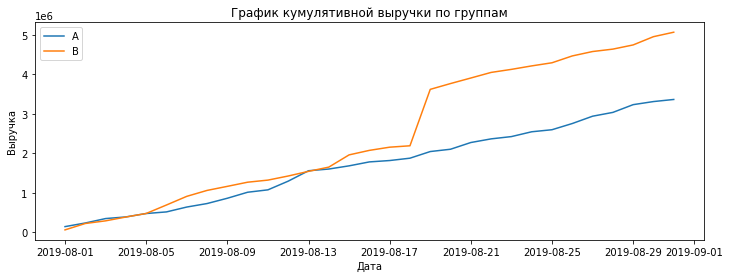

In [25]:
# Объявим переменные cumulative_revenue_a и cumulative_revenue_b, в которых сохраним данные о датах, выручке и числе заказов в группах A и B. 
# Построим графики кумулятивной выручки по дням по группам

# Переменная с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# Переменная с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,4))
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('График кумулятивной выручки по группам', size=12)
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.legend()
plt.show()

#### Промежуточный вывод 

Видим, что кумулятивная выручка группы B выше, однако между 2019-08-17 и 2019-08-21 наблюдаем резкий скачок, это может говорить об аномалии вызванной некоторым количеством очень дорогих заказов. 

### График кумулятивного среднего чека по группам

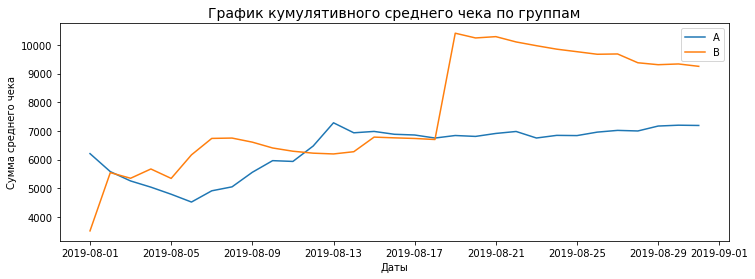

In [26]:
plt.figure(figsize=(12,4))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам', size=14)
plt.xlabel("Даты")
plt.ylabel("Сумма среднего чека")
plt.legend()
plt.show()

#### Промежуточный вывод 

На графике кумулятивного среднего чека по группам мы так же видим резкий скачок у группы B в районе 2019-08-17 и 2019-08-21. При этом у группы А средний чек держится на одном уровне примерно с середины месяца, кажется в группе В действительно появилось некоторое количество очень дорогих заказов. 

### График относительного изменения кумулятивного среднего чека группы B к группе A

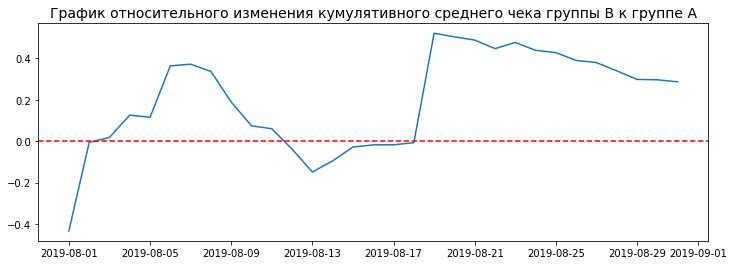

In [27]:
# Передадим перменной merg_cum_rev данные из cumulative_revenue_a и cumulative_revenue_b

merg_cum_rev = cumulative_revenue_a.merge(cumulative_revenue_b, left_on = 'date',\
                                          right_on = 'date', how = 'left', suffixes=['_a', '_b'])

# Строим график относительно различия кумулятивного среднего чека группы B к группе A 

plt.figure(figsize=(12,4))
plt.plot(merg_cum_rev['date'], (merg_cum_rev['revenue_b'] / merg_cum_rev['orders_b']) / (merg_cum_rev['revenue_a'] / merg_cum_rev['orders_a']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=14)

# добавляем ось X

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.show()

#### Промежуточный вывод

График показывает несколько колебаний относительного кумулятивного среднего, вероятно причина в аномальных заказах.

### График кумулятивного среднего количества заказов на посетителя по группам

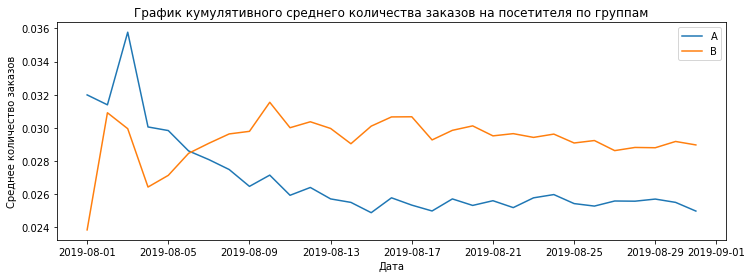

In [28]:
# Добавим в cumulative_data столбец 'conversion' c отношением числа заказов к количеству пользователей в указанной группе.

# Объявим переменные cumulative_data_a и cumulative_data_b, в которых сохраним данные о заказах в сегментах A и B.

# Cчитаем Кумулятивное среднее количество заказов 
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# Кумулятивное среднее количество заказов группы A
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']

# Кумулятивное среднее количество заказов  группы B
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

plt.figure(figsize = (12,4))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A');
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B');
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel("Дата")
plt.ylabel("Среднее количество заказов")
plt.legend()
plt.show()

#### Промежуточный вывод

Видим, что изначально среднее количество заказов группы А было выше, чем у группы B, однако с примерно с шестого дня ситуация изменилась и среднее кол-во заказов группы В резко выросло. Примерно с середины месяца показатели групп начали стабилизироваться.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

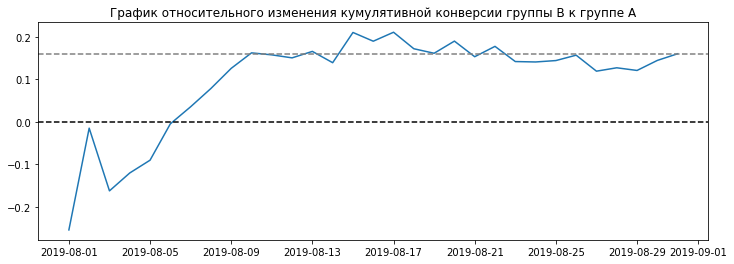

In [29]:
# В merg_cumltv_conversions объединим cumulative_data_a и cumulative_data_b

merg_cumltv_conversions = cumulative_data_a[['date','conversion']] \
.merge(cumulative_data_b[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])

plt.figure(figsize=(12,4))
plt.plot(merg_cumltv_conversions['date'], merg_cumltv_conversions['conversionB'] / merg_cumltv_conversions['conversionA'] - 1, \
         label = "Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size = 12)

plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.16, color = 'grey', linestyle = '--')

#### Промежуточный вывод

Кумулятивная конверсия группы B с шестого дня начала расти и с десятого дня начала стабилизироваться на уровне 15% выше конверсии группы А

### Точечный график количества заказов по пользователям

In [30]:
#Создадим датафрейм с количеством заказов на каждого пользователя 

orders_per_user = (orders.drop(['group', 'revenue', 'date'], axis=1)
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id' : pd.Series.nunique})
                  )
orders_per_user.columns = ['visitor_id','orders']
orders_per_user.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


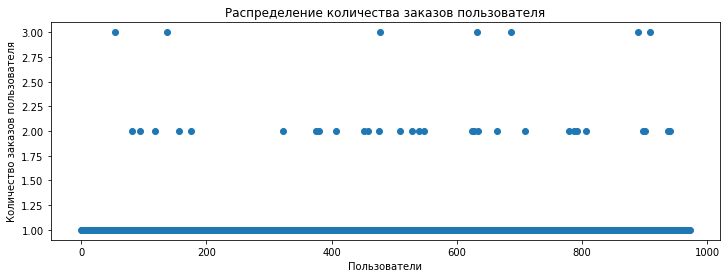

In [31]:
# Строим точечный график распределения количества заказов по пользователям

plt.figure(figsize=(12,4))
plt.scatter(pd.Series(range(0,len(orders_per_user['orders']))), orders_per_user['orders'])
plt.title('Распределение количества заказов пользователя')
plt.ylabel('Количество заказов пользователя')
plt.xlabel('Пользователи')
plt.show()

#### Промежуточный вывод 

Большинство пользователей делают только один заказ, но есть некоторое количество пользователей, которые совершают по 2 заказа и небольшое количество тех, кто делает от 3 до 11 заказов.

### Поиск 95-го и 99-го перцентиля количества заказов на пользователя.

In [32]:
print(np.percentile(orders_per_user['orders'], [95, 99]))

[1. 2.]


#### Промежуточный выбор 

Видим, что не более 5% пользователей делают более 1 заказа и не более 1% более 2 заказов. Следовательно можем считать, что пользователи совершившие больше одного заказа - аномалия.  

### Точечный график стоимостей заказов

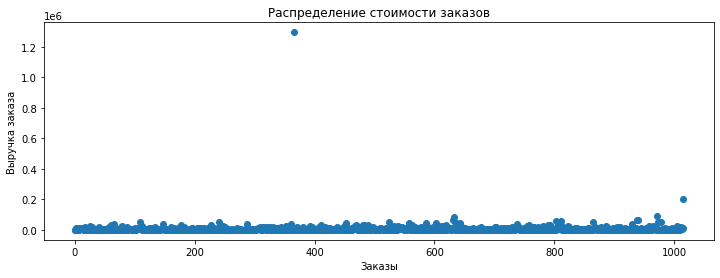

In [33]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Выручка заказа')
plt.xlabel('Заказы')
plt.show()

#### Промежуточный вывод

Видим значительную аномалию в заказе стоимостью больше 1,2 млн. 

### Поиск 95-го и 99-го перцентиля стоимости заказов. 

In [34]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


#### Промежуточный вывод 

Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Соответственно, заказы дороже 26785 можем считать аномальными.

###  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [35]:
# Подготовим сырые данные для работы 

# Объявим переменные с информацией о ежедневном количестве пользователей по группам
# и переменные с кумулятивным количеством пользователей к дате по группам

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


# Объявим переменные с количеством заказов и размером выручки по группам
# и создадим таблицы с кумулятивным количеством заказов и выручки

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [36]:
# Создадим таблицы с количеством заказов по пользователям для каждой группы

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Посмотрим, есть ли статическая значимость различий в среднем количестве заказов на посетителя по группам и какой относительный прирост группы B при помощи непараметрического критерия Манна-Уитни.

Сфорулируем нулевую и альтернативную гипотезы так: 

- H0 - Статситически значимых различий в среднем количестве заказов между группами А и B по "сырым" данным нет

- H1 - Статситически значимые различия в среднем количестве заказов между группами А и B по "сырым" данным есть

Уровень статистической значимости возьмем 0.05.

In [37]:
# Посчитаем критерий Манна-Уитни к конверсии и относительный прирост конверсии группы B

print('Значение p-value: {:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост в среднем количестве заказов группы B: {:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

Значение p-value: 0.011
Относительный прирост в среднем количестве заказов группы B: 15.98%


#### Промежуточный вывод 

P-value меньше 0.05, значит нулевую гипотезу отвергаем. Анализ «сырых данных» показывает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.



### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем нулевую и альтернативную гипотезы так: 

- H0 - Статистической значимости различий в среднем чеке между группами А и В нет
- H1 - Статистическая значимость различий в среднем чеке между группами А и В есть

In [38]:
# Посчитаем критерий Манна-Уитни к среднему чеку и относительный прирост среднего чека группы B

print('Значение p-value для среднего чека: {:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('Относительный прирост среднего чека группы B: {:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Значение p-value для среднего чека: 0.829
Относительный прирост среднего чека группы B: 28.66%


#### Промежуточный вывод

P-value больше 0.05 — значит нулевую гипотезу не отвергаем, статистически значимых различий нет. Наблюдаемое различие в 25.87% не является статистически значимым 

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [39]:
# Подготовим "очищенные" данные 

# Если у пользователя больше одного заказа, то это аномальный пользователь 
# Если сумма одного заказа больше 26785, то это аномальный заказ 

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print('Количество аномальных пользователей:',len(abnormalUsers))
print('Доля аномальных пользователей {:.2%}'.format(len(abnormalUsers) / len(orders['visitor_id'].unique())))

Количество аномальных пользователей: 86
Доля аномальных пользователей 8.84%


In [40]:
# Cоздадим таблицы с количеством заказов по пользователям для каждой группы без аномальных пользователей

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


**Рассчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Зададим уровень статистической значимости в 0.05 

Нулевую и альтернативную гипотезы сформулируем так: 

- H0: статистически значимых различий в среднем количестве заказов на посетителя между группами нет.
- H1: статистически значимые различия в среднем количестве заказов на посетителя между группами есть.


In [41]:

print('Значение p-value для конверсий: {:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост группы B: {:.2%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Значение p-value для конверсий: 0.016
Относительный прирост группы B: 17.39%


#### Промежуточный вывод

Статистическая значимость достигнута - p-value 0.016, что меньше 0.05. Соответственно отвергаем нулевую гипотезу и принимаем альтернативную - статистически значимые различия в среднем количестве заказов на посетителя между группами есть. А прирост у группы В составляет 17.39%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим, есть ли статистическая значимость различий в среднем чеке между группами в очищенных данных с помощью критерия Манна-Уитни. 

Сформулируем нулевую и альтернативную гипотезы так: 

- H0: статистической значимости в различиях в среднем чеке заказа между группами нет 
- H1: статистическая значимость в различиях в среднем чеке заказа между группами есть 

Уровень стат. значимости alpha = 0.05

И посчитаем относительный прирост среднего чека в группе В по очищенным данным.

In [42]:
print(
    'Значение p-value для среднего чека: {:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека группы B: {:.2%}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Значение p-value для среднего чека: 0.727
Относительный прирост среднего чека группы B: -3.37%


#### Промежуточный вывод

Значение p-value для среднего чека: 0.762, что сильно больше 0.05, значит нулевую гипотезу не отвергаем. Также видим, что относительный прирост среднего чека группы В на "очищенных" данных изменился до -2.24%. Тем не менее статистической значимости в различиях в среднем чеке между группами нет